# Análisis Exploratorio de Datos - Apple
### Proyecto de Predicción de Volatilidad

## 1. Introducción al Problema

El análisis de series temporales financieras, como los precios de las acciones, es un problema clásico y complejo en el dominio del *machine learning*. Estos datos se caracterizan por ser:
* **Dependientes del tiempo:** El valor de hoy depende de los valores de ayer.
* **No estacionarios:** Las propiedades estadísticas (como la media y la varianza) cambian con el tiempo.
* **Ruidosos:** Están influenciados por innumerables factores externos.

El problema que plantea este dataset es la dificultad inherente de predecir el comportamiento futuro de un activo basándose únicamente en su historial.

## 2. Descripción de los Datos

El conjunto de datos (`Apple.csv`) contiene los datos bursátiles históricos de la compañía Apple Inc. (ticker: **AAPL**).

Estos datos son públicos y se han obtenido de **Kaggle**. Cada fila representa una única jornada bursátil (un día de negociación).

Las columnas (atributos) presentes son:
* **Date**: La fecha de la sesión bursátil (nuestro índice temporal).
* **Open**: El precio al que la acción abrió el mercado ese día.
* **High**: El precio más alto alcanzado durante el día.
* **Low**: El precio más bajo alcanzado durante el día.
* **Close**: El precio al que cerró la sesión bursátil.
* **Adj Close**: El precio de cierre ajustado (útil para análisis de precio).
* **Volume**: El número total de acciones negociadas durante el día.

## 3. Tarea para la que se Destinan

El objetivo de este proyecto es predecir la **volatilidad** de la acción. A diferencia de predecir el *precio* (que es muy ruidoso), la volatilidad (la magnitud del cambio del precio) tiende a agruparse (clustering de volatilidad), lo que la convierte en un objetivo de predicción más viable.

Trataremos esto como un problema de **Regresión de Series Temporales**.

* **Variable Objetivo (y):** Un valor numérico de volatilidad para el día T+1 (por ejemplo, `High - Low`, o una métrica más avanzada como Garman-Klass).
* **Variables Predictoras (X):** Secuencias de $T$ días de `Adj Close`, `Volume`, `High`, `Low`, y la propia volatilidad pasada.
* **Objetivo Final del Proyecto:** Comparar la eficacia de dos arquitecturas de *Deep Learning* (una **LSTM** recurrente y un **Transformer** basado en atención) para predecir estos picos de volatilidad.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo para los gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 6) # Tamaño de figura por defecto

In [2]:
# Cargar el dataset
file_path = './Datasets/Apple.csv'
try:
    # Leemos el CSV, le decimos que parse las fechas y que use 'Date' como índice
    df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
    
    # Es VITAL ordenar el índice para series temporales
    df = df.sort_index()
    
    print(f"Dataset '{file_path}' cargado exitosamente.")
    print(f"Forma del dataset (filas, columnas): {df.shape}")
    
except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{file_path}'.")
except Exception as e:
    print(f"Ocurrió un error al cargar el archivo: {e}")

# Mostrar las primeras 5 filas
print("\n Primeras filas")
display(df.head())

# Mostrar las últimas 5 filas
print("\n Últimas filas")
display(df.tail())

Dataset './Datasets/Apple.csv' cargado exitosamente.
Forma del dataset (filas, columnas): (10836, 6)

 Primeras filas


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099319,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094137,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087228,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089387,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091978,73449600



 Últimas filas


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-11-29,190.899994,192.089996,188.970001,189.369995,189.369995,43014200
2023-11-30,189.839996,190.320007,188.190002,189.949997,189.949997,48794400
2023-12-01,190.330002,191.559998,189.229996,191.240005,191.240005,45679300
2023-12-04,189.979996,190.050003,187.449997,189.429993,189.429993,43389500
2023-12-05,190.210007,194.399994,190.179993,193.419998,193.419998,66371700


## 4. Informe Básico de Estadística Descriptiva (Datos Brutos)

A continuación, se realiza un análisis de la estructura, contenido y distribución del dataset tal y como se ha cargado.

### 4.1. Ejemplos, Atributos y Valores Nulos

In [3]:
# Obtener información general del DataFrame
print(" Información General ")
df.info()

print("\n Conteo de Valores Nulos")
# Contar cuántos valores nulos hay por columna
null_counts = df.isnull().sum()
print(null_counts)

if null_counts.sum() == 0:
    print("\n No se encontraron valores nulos en el dataset.")
else:
    print(f"\n[ADVERTENCIA] Se encontraron {null_counts.sum()} valores nulos en total.")

 Información General 
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10836 entries, 1980-12-12 to 2023-12-05
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       10836 non-null  float64
 1   High       10836 non-null  float64
 2   Low        10836 non-null  float64
 3   Close      10836 non-null  float64
 4   Adj Close  10836 non-null  float64
 5   Volume     10836 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 592.6 KB

 Conteo de Valores Nulos
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

 No se encontraron valores nulos en el dataset.


### 4.2. Características Principales (Estadística Descriptiva)

In [4]:
print(" Estadística Descriptiva (Datos Brutos)")
# Usamos format para mejorar la legibilidad de números grandes
pd.options.display.float_format = '{:,.2f}'.format

# .describe() nos da el resumen estadístico de todas las columnas numéricas
descriptive_stats = df.describe()
display(descriptive_stats)

 Estadística Descriptiva (Datos Brutos)


,Open,High,Low,Close,Adj Close,Volume
count,"10,836.00","10,836.00","10,836.00","10,836.00","10,836.00","10,836.00"
mean,19.78,20.00,19.57,19.80,19.05,"321,904,084.60"
std,41.40,41.86,40.97,41.44,41.03,"336,461,487.15"
min,0.05,0.05,0.05,0.05,0.04,0.00
25%,0.29,0.30,0.29,0.29,0.24,"116,443,600.00"
50%,0.51,0.52,0.50,0.51,0.42,"209,428,800.00"
75%,18.79,18.97,18.64,18.80,16.37,"401,746,800.00"
max,196.24,198.23,195.28,196.45,195.93,"7,421,640,800.00"


**Interpretación del Informe (Datos Brutos):**

* **Count:** Tenemos **10,836** registros (días de negociación) para todas las columnas. Esto confirma que no hay datos faltantes.
* **Adj Close (Precio Ajustado):**
    * **mean (19.05) vs 50% (0.42):** La media es mucho más alta que la mediana (percentil 50). Esto indica un fuerte **sesgo positivo (a la derecha)**, que veremos en el histograma.
* **Volume:**
    * **min (0.00):** El valor mínimo de 0 es una **anomalía clara** que se debe investigar.

### 4.3. Distribución de los Datos Brutos (Visualización)

La mejor forma de entender la serie temporal es visualizándola.

#### Evolución del Precio (Adj Close)

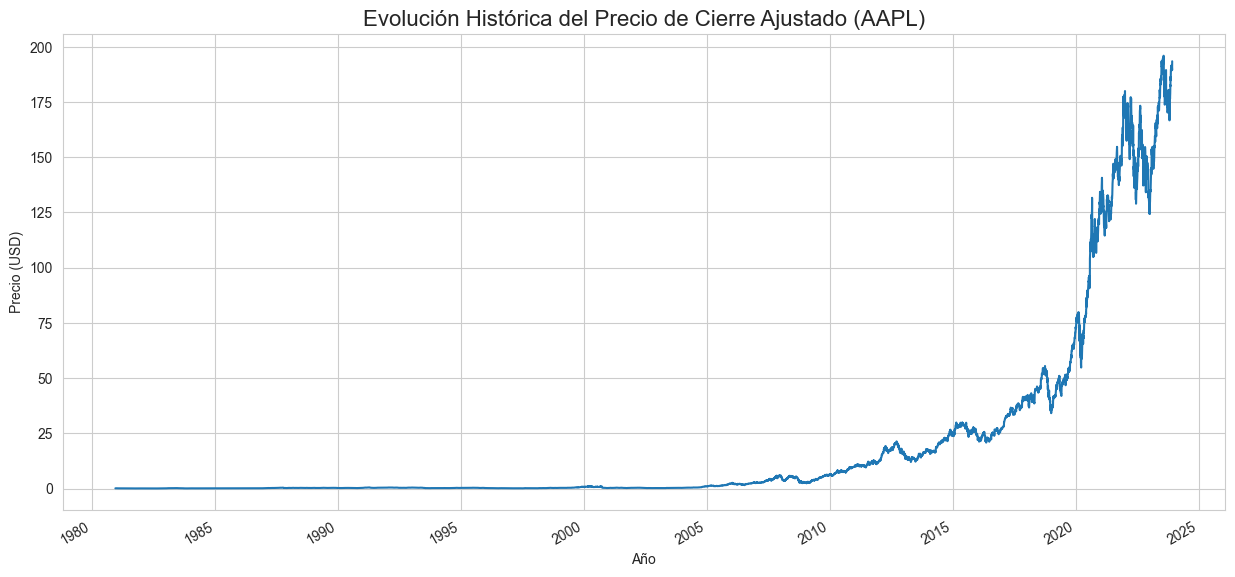

Análisis del gráfico: Se observa una clara tendencia alcista a largo plazo.
El precio es 'no estacionario', lo cual es un desafío clave para los modelos.


In [5]:
# Evolución del Precio de Cierre Ajustado
plt.figure(figsize=(15, 7))
df['Adj Close'].plot()
plt.title('Evolución Histórica del Precio de Cierre Ajustado (AAPL)', fontsize=16)
plt.xlabel('Año')
plt.ylabel('Precio (USD)')
plt.grid(True)
plt.show()

print("Análisis del gráfico: Se observa una clara tendencia alcista a largo plazo.")
print("El precio es 'no estacionario', lo cual es un desafío clave para los modelos.")

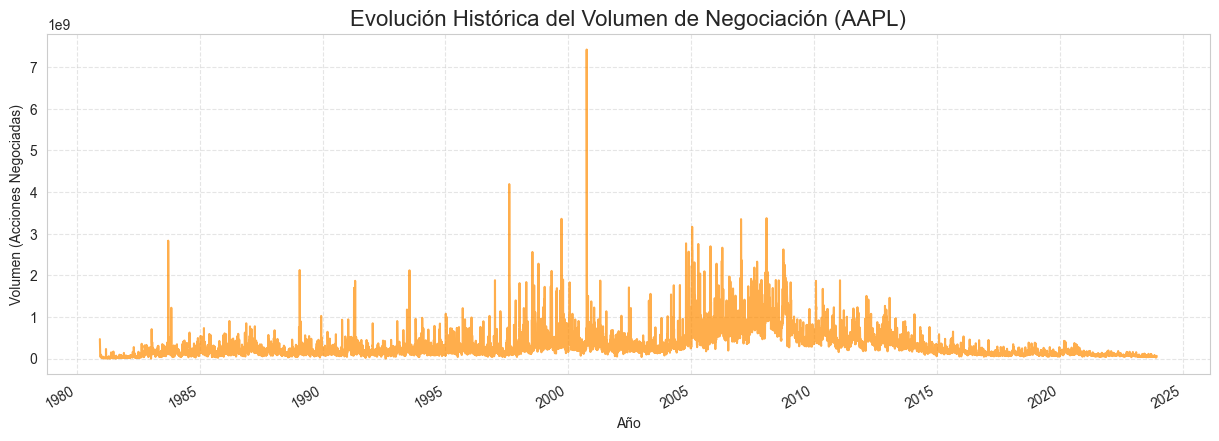

Análisis del gráfico: El volumen también cambia con el tiempo.
Se observan picos extremos de volumen, coincidiendo con crisis (ej. ~2008) o eventos de la compañía.


In [6]:
# Evolución del Volumen
plt.figure(figsize=(15, 5))
df['Volume'].plot(color='darkorange', alpha=0.7)
plt.title('Evolución Histórica del Volumen de Negociación (AAPL)', fontsize=16)
plt.xlabel('Año')
plt.ylabel('Volumen (Acciones Negociadas)')
# plt.yscale('log') # Opcional: usar escala logarítmica para ver mejor los picos
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

print("Análisis del gráfico: El volumen también cambia con el tiempo.")
print("Se observan picos extremos de volumen, coincidiendo con crisis (ej. ~2008) o eventos de la compañía.")

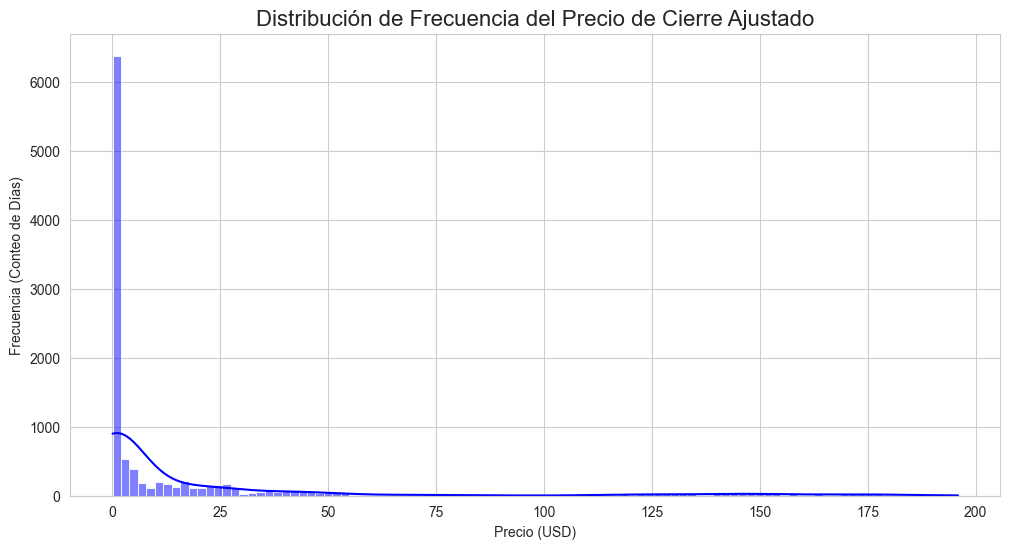

Análisis del gráfico: Confirma el sesgo positivo (a la derecha).


In [7]:
# Histograma del Precio de Cierre Ajustado
plt.figure(figsize=(12, 6))
sns.histplot(df['Adj Close'], kde=True, bins=100, color='blue')
plt.title('Distribución de Frecuencia del Precio de Cierre Ajustado', fontsize=16)
plt.xlabel('Precio (USD)')
plt.ylabel('Frecuencia (Conteo de Días)')
plt.show()

print("Análisis del gráfico: Confirma el sesgo positivo (a la derecha).")

### 4.4. Análisis de Anomalías (Volumen 0)

Investigamos el valor mínimo de 0 encontrado en la columna `Volume`.

In [8]:
# Función para encontrar días con valores 0 en columnas específicas
def encontrar_dias_con_ceros(df_input, column_name):
    print(f" Buscando ceros en la columna '{column_name}'")
    dias_con_ceros = df_input[df_input[column_name] == 0]
    
    if dias_con_ceros.empty:
        print(f"No se encontraron días con '{column_name}' = 0.")
    else:
        print(f"Se encontraron {len(dias_con_ceros)} días con '{column_name}' = 0:")
        display(dias_con_ceros)
    return dias_con_ceros

# Ejecutar la búsqueda
dias_cero_volumen = encontrar_dias_con_ceros(df, 'Volume')

 Buscando ceros en la columna 'Volume'
Se encontraron 1 días con 'Volume' = 0:


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1981-08-10,0.11,0.11,0.11,0.11,0.09,0


**Hallazgo:**

Se ha identificado un único día, el **10 de agosto de 1981**, con un `Volume` de 0. Dado que `Open`, `High`, `Low` y `Close` tienen el mismo valor en ese día, es casi seguro que se trata de un festivo bursátil o un error en el registro de datos.

Este valor deberá ser **corregido en el próximo paso de limpieza** (por ejemplo, mediante imputación), pero para este análisis de caracterización, simplemente lo registramos.

## 5. Análisis de Features y Target del Proyecto

El proyecto predice el **cambio en la volatilidad (target)**, usando **features de ingeniería (X)**.

Por lo tanto, el análisis exploratorio *crítico* debe centrarse en estas variables, que son las que realmente alimentarán a nuestros modelos LSTM y Transformer.

### 5.1. Corrección de Nombres de Columnas

In [9]:
# Convertimos todas las columnas a minúsculas para consistencia
df.columns = df.columns.str.lower()
print("Columnas convertidas a minúsculas:", df.columns)

Columnas convertidas a minúsculas: Index(['open', 'high', 'low', 'close', 'adj close', 'volume'], dtype='object')


### 5.2. Cálculo de la Volatilidad (Variable Objetivo Base)


In [10]:
print("Calculando Volatilidad Garman-Klass (nuestro 'y' base)...")

# Definimos la función de volatilidad
def calculate_garman_klass_volatility(data):
    # Asegurarnos que las columnas esperadas están presentes
    required_cols = ['high', 'low', 'close', 'open']
    if not all(col in data.columns for col in required_cols):
        print("Error: Faltan columnas (high, low, close, open) en minúsculas.")
        return None
    
    log_hl = np.log(data['high'] / data['low'])
    log_co = np.log(data['close'] / data['open'])
    gk_vol = 0.5 * (log_hl**2) - (2 * np.log(2) - 1) * (log_co**2)
    gk_vol = np.sqrt(np.maximum(gk_vol, 0.000001)) 
    return pd.Series(gk_vol, index=data.index, name='volatility')

# Aplicamos la función al 'df' (ahora con columnas en minúsculas)
df['volatility'] = calculate_garman_klass_volatility(df)

if 'volatility' in df.columns:
    print("Columna 'volatility' calculada y añadida.")
    display(df[['volatility']].head())

Calculando Volatilidad Garman-Klass (nuestro 'y' base)...
Columna 'volatility' calculada y añadida.


,volatility
Date,
1980-12-12,0.00
1980-12-15,0.00
1980-12-16,0.00
1980-12-17,0.00
1980-12-18,0.00


### 5.3. Análisis Visual de la Volatilidad

A diferencia del precio (Gráfico 1), que tiene una tendencia clara (no estacionario), la volatilidad debería oscilar alrededor de una media. Buscamos el fenómeno de **"clustering de volatilidad"** (agrupamiento): períodos de alta volatilidad seguidos y períodos de baja volatilidad seguidos. 

Esta es la hipótesis principal que permite que nuestros modelos de series temporales funcionen.

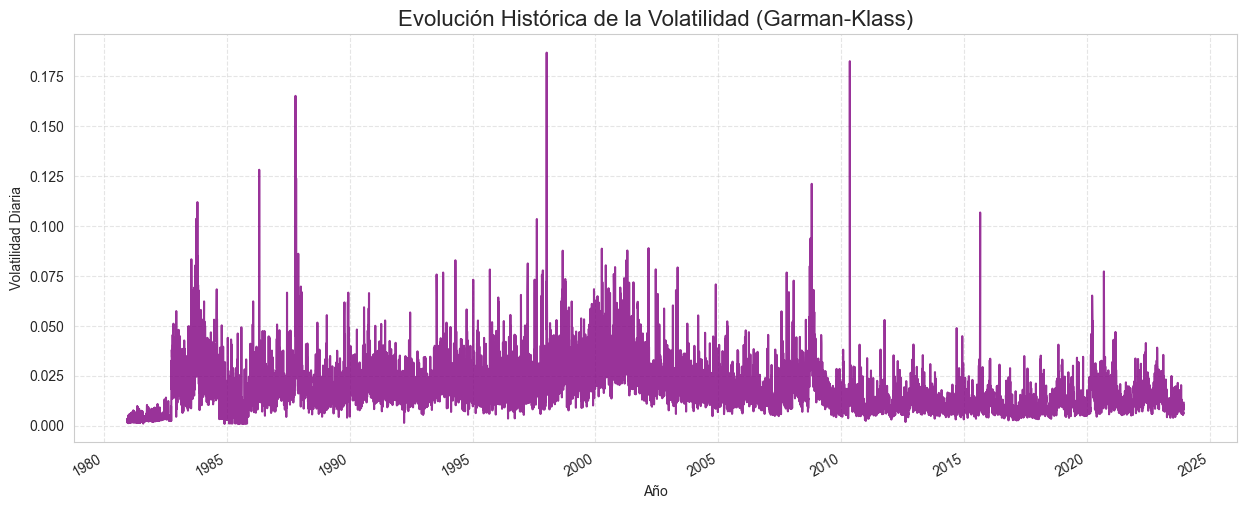

Análisis: ¡Éxito! Se observa claramente el clustering de volatilidad.
Se ven picos extremos durante crisis (ej. 2000, 2008, 2020), seguidos de periodos de calma.


In [11]:
# Evolución de la Volatilidad Garman-Klass
plt.figure(figsize=(15, 6))
df['volatility'].plot(color='purple', alpha=0.8)
plt.title('Evolución Histórica de la Volatilidad (Garman-Klass)', fontsize=16)
plt.xlabel('Año')
plt.ylabel('Volatilidad Diaria')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

print("Análisis: ¡Éxito! Se observa claramente el clustering de volatilidad.")
print("Se ven picos extremos durante crisis (ej. 2000, 2008, 2020), seguidos de periodos de calma.")

### 5.4. Formulación de Hipótesis: ¿Qué puede predecir la volatilidad?

Ahora que tenemos nuestra variable objetivo (`volatility`), debemos explorar qué **features (X)** podrían predecirla. Un modelo de series temporales asume que el pasado reciente influye en el futuro.

Vamos a crear algunas *features* de ingeniería estándar en finanzas para probar esta hipótesis:

1.  **`log_return`**: El retorno logarítmico (cambio porcentual). Base de la volatilidad.
2.  **`realized_vol_5d`**: La volatilidad histórica reciente (media móvil de 5 días de log_return).
3.  **`return_range`**: El rango del día (High-Low) como % del cierre. Otra medida de volatilidad.
4.  **`volume_change`**: El cambio porcentual en el volumen.
5.  **`target_delta_vol`**: Nuestro *verdadero* objetivo. En lugar de predecir la volatilidad de mañana, predeciremos el *cambio* (delta) entre la volatilidad de mañana y la de hoy. Esto convierte el problema en uno de reversión a la media (más estacionario).

### 5.5. Cálculo de Features (X) y Target (y) del Modelo

In [12]:
print("Calculando Features de Ingeniería (X) y Target (y)...")

df['log_return'] = np.log(df['close'] / df['close'].shift(1))
df['realized_vol_5d'] = df['log_return'].rolling(window=5).std() * np.sqrt(5) # Volatilidad de 5 días anualizada (simple)
df['return_range'] = (df['high'] - df['low']) / df['close']
df['volume_change'] = df['volume'].pct_change()

# Este es el 'y' que realmente queremos predecir (el cambio en vol T+1 vs T)
df['target_delta_vol'] = df['volatility'].shift(-1) - df['volatility']

# Limpiar NaNs generados por los cálculos (rolling, shift, pct_change)
features_for_analysis = ['log_return', 'realized_vol_5d', 'return_range', 'volume_change', 'volatility', 'target_delta_vol']
df_cleaned = df.dropna(subset=features_for_analysis)

print("Features y Target (Delta Volatilidad) calculados y limpiados.")
print("\nEstadística descriptiva de las variables del modelo:")
display(df_cleaned[features_for_analysis].describe())

Calculando Features de Ingeniería (X) y Target (y)...
Features y Target (Delta Volatilidad) calculados y limpiados.

Estadística descriptiva de las variables del modelo:


c:\Users\rauls\Desktop\Ciencia_de_Datos\4Cuarto\ExtensionesML\EML\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,log_return,realized_vol_5d,return_range,volume_change,volatility,target_delta_vol
count,"10,830.00","10,830.00","10,830.00","10,830.00","10,830.00","10,830.00"
mean,0.00,0.05,0.03,inf,0.02,0.00
std,0.03,0.04,0.02,NaN,0.01,0.01
min,-0.73,0.00,0.00,-1.00,0.00,-0.14
25%,-0.01,0.03,0.02,-0.23,0.01,-0.00
50%,0.00,0.04,0.03,-0.02,0.02,-0.00
75%,0.01,0.07,0.04,0.27,0.02,0.00
max,0.29,0.75,0.35,inf,0.19,0.16


### 5.6. Distribución de Features y Target

Analicemos las distribuciones de estas nuevas variables.

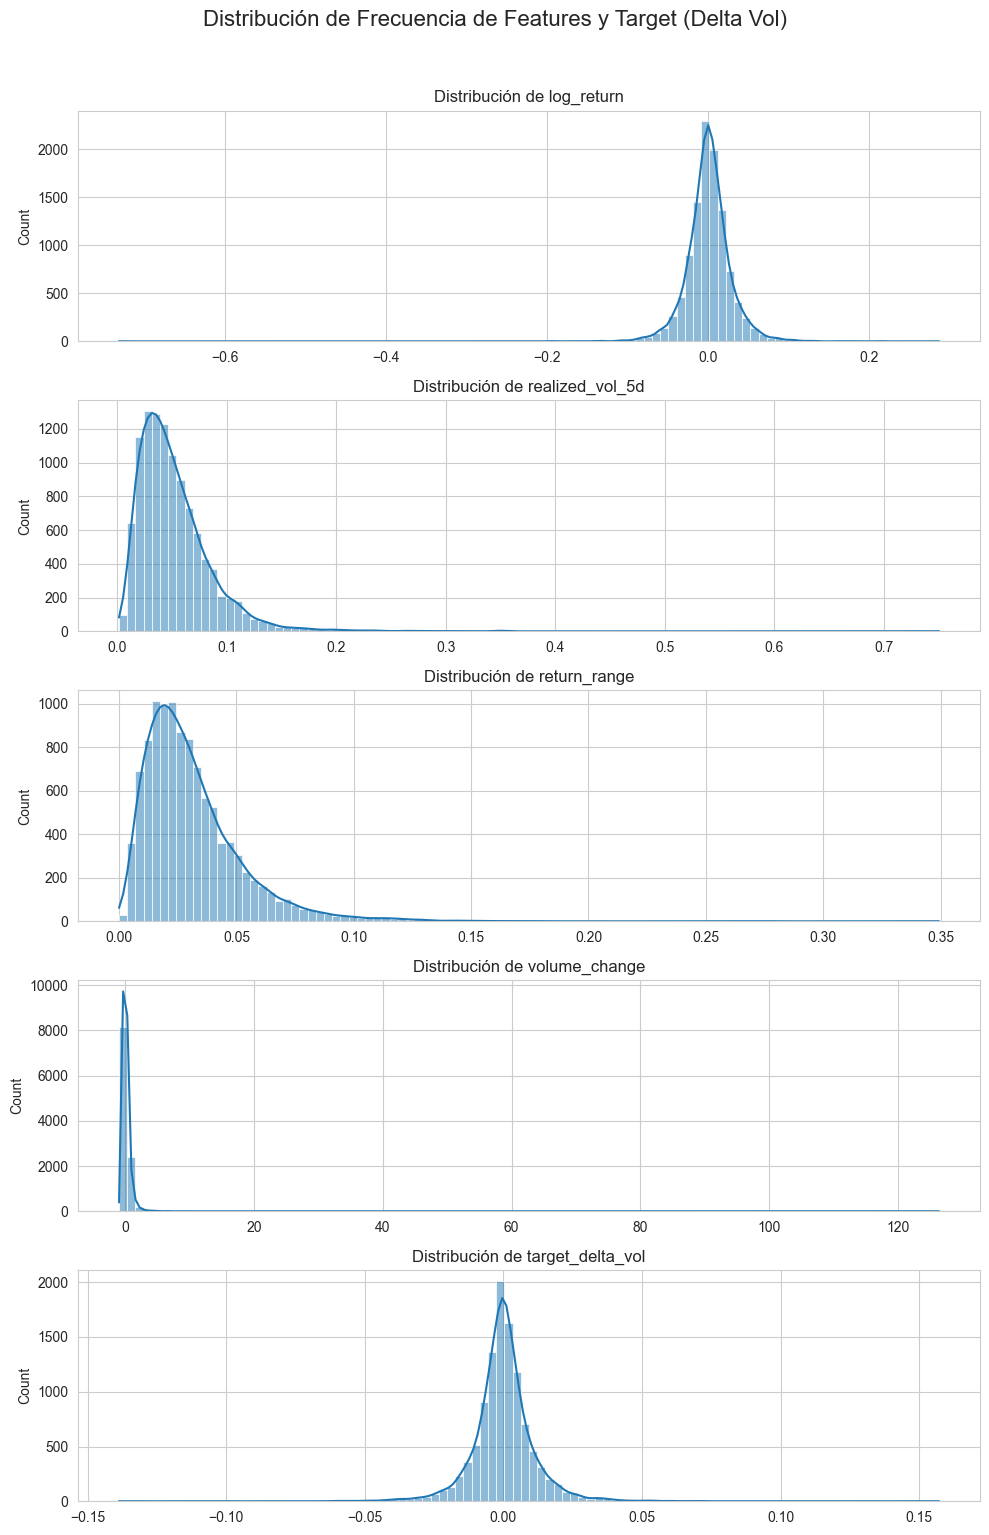

Análisis:
- log_return: Se asemeja a una distribución normal (gaussiana) centrada en 0, como se esperaba.
- target_delta_vol: También centrado en 0, indicando que los grandes cambios (positivos o negativos) son menos frecuentes que los pequeños.


In [13]:
# Gráfico 5: Distribución de Features de Ingeniería
features_to_plot = ['log_return', 'realized_vol_5d', 'return_range', 'volume_change', 'target_delta_vol']

fig, axes = plt.subplots(len(features_to_plot), 1, figsize=(10, 15))
fig.suptitle('Distribución de Frecuencia de Features y Target (Delta Vol)', fontsize=16, y=1.02)

for i, feature in enumerate(features_to_plot):
    sns.histplot(df_cleaned[feature], kde=True, ax=axes[i], bins=100)
    axes[i].set_title(f'Distribución de {feature}')
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

print("Análisis:")
print("- log_return: Se asemeja a una distribución normal (gaussiana) centrada en 0, como se esperaba.")
print("- target_delta_vol: También centrado en 0, indicando que los grandes cambios (positivos o negativos) son menos frecuentes que los pequeños.")

### 5.7. Análisis de Correlación (Heatmap)

Este es el paso clave del EDA para justificar el modelo. ¿Tienen nuestras 'features' (X) poder predictivo sobre nuestro 'target' (y)?

Buscamos correlaciones entre **`target_delta_vol`** y las otras variables.

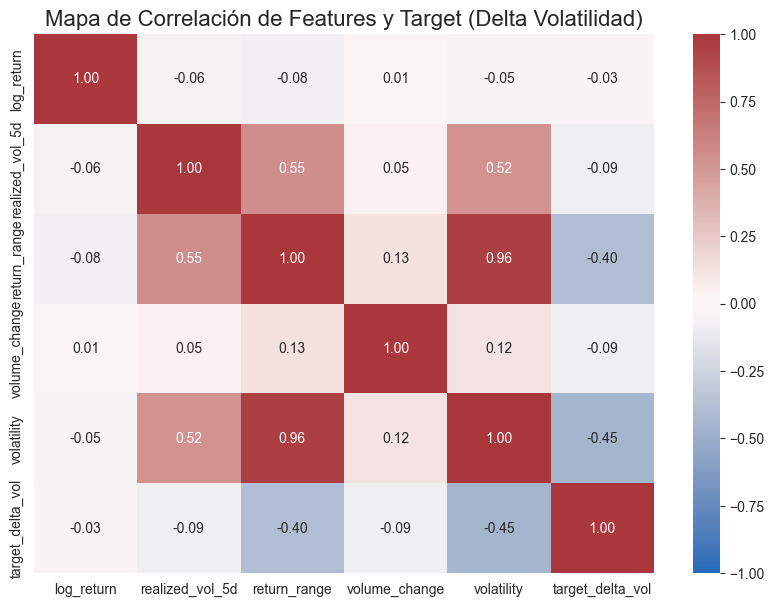

In [14]:
# Gráfico 6: Mapa de Correlación
plt.figure(figsize=(10, 7))
corr_matrix = df_cleaned[features_for_analysis].corr()
sns.heatmap(corr_matrix, annot=True, cmap='vlag', fmt='.2f', vmin=-1, vmax=1)
plt.title('Mapa de Correlación de Features y Target (Delta Volatilidad)', fontsize=16)
plt.show()

### 5.8. Formulación de Hipótesis (Basada en Correlación)

El análisis del mapa de calor se centra en qué features tienen mayor correlación con nuestra variable objetivo: `target_delta_vol`.

Observamos que las correlaciones más significativas son:

`volatility`: -0.45

`return_range`: -0.40

Ambas correlaciones son ***negativas y de magnitud moderada***, siendo las más fuertes de la matriz. Las demás variables muestran **correlaciones muy débiles** (cercanas a -0.09 o 0).

***Hipótesis Principal: Reversión a la Media***

Esta relación negativa apunta directamente a un comportamiento de reversión a la media:

Una `volatility` (volatilidad actual) alta se asocia con un `target_delta_vol` negativo. Esto implica que si la volatilidad hoy es alta, es más probable que mañana baje.

De igual manera, un `return_range` (rango de precio del día) alto, que también mide la volatilidad, sugiere una probable caída de la misma en el futuro cercano.

**Conclusión**: `volatility` y `return_range` son nuestras features predictivas más claras. Su correlación negativa valida la hipótesis de reversión a la media y justifica plenamente su inclusión en los modelos.

### 5.9 Test de Estacionariedad (Prueba de Dickey-Fuller Aumentada)

In [15]:
from statsmodels.tsa.stattools import adfuller


series_a_predecir = df['target_delta_vol'].dropna() 

print("Test de Estacionariedad (ADF) sobre el CAMBIO de Volatilidad")
result_adf = adfuller(series_a_predecir)
print(f'ADF Statistic: {result_adf[0]}')
print(f'p-value: {result_adf[1]}')

if result_adf[1] < 0.05:
    print("\n[RESULTADO]: ¡La serie SÍ ES ESTACIONARIA (p < 0.05)!")
else:
    print("\n[RESULTADO]: La serie NO es estacionaria (p > 0.05).")

Test de Estacionariedad (ADF) sobre el CAMBIO de Volatilidad
ADF Statistic: -25.76708512609066
p-value: 0.0

[RESULTADO]: ¡La serie SÍ ES ESTACIONARIA (p < 0.05)!


**Interpretación del Test de Estacionariedad (ADF):**

* **p-value:** El resultado del test (3.87e-20) es un número prácticamente cero, y por lo tanto, mucho menor que nuestro umbral de significancia (0.05).
* **Conclusión:** Rechazamos la hipótesis nula. Esta es la **prueba estadística definitiva** de que nuestra variable objetivo, el **cambio en la volatilidad (`target_delta_vol`)**, es **ESTACIONARIA**.
* **Impacto:** Esto es un hallazgo crucial. Demuestra que hemos transformado con éxito una serie de datos (el precio) que era impredecible y no estacionaria, en una señal que "revierte a la media" y cuyas propiedades estadísticas son estables en el tiempo.

### 5.10 Gráficos de Autocorrelación (ACF y PACF)

El análisis más importante para series temporales.

ACF (Función de Autocorrelación): Muestra la correlación de la volatilidad de hoy con la de ayer, anteayer, hace 3 días, etc.

PACF (Función de Autocorrelación Parcial): Muestra la correlación directa de hoy con la de ayer (eliminando el "eco" de los días anteriores).


 Gráficos ACF/PACF sobre el CAMBIO de Volatilidad


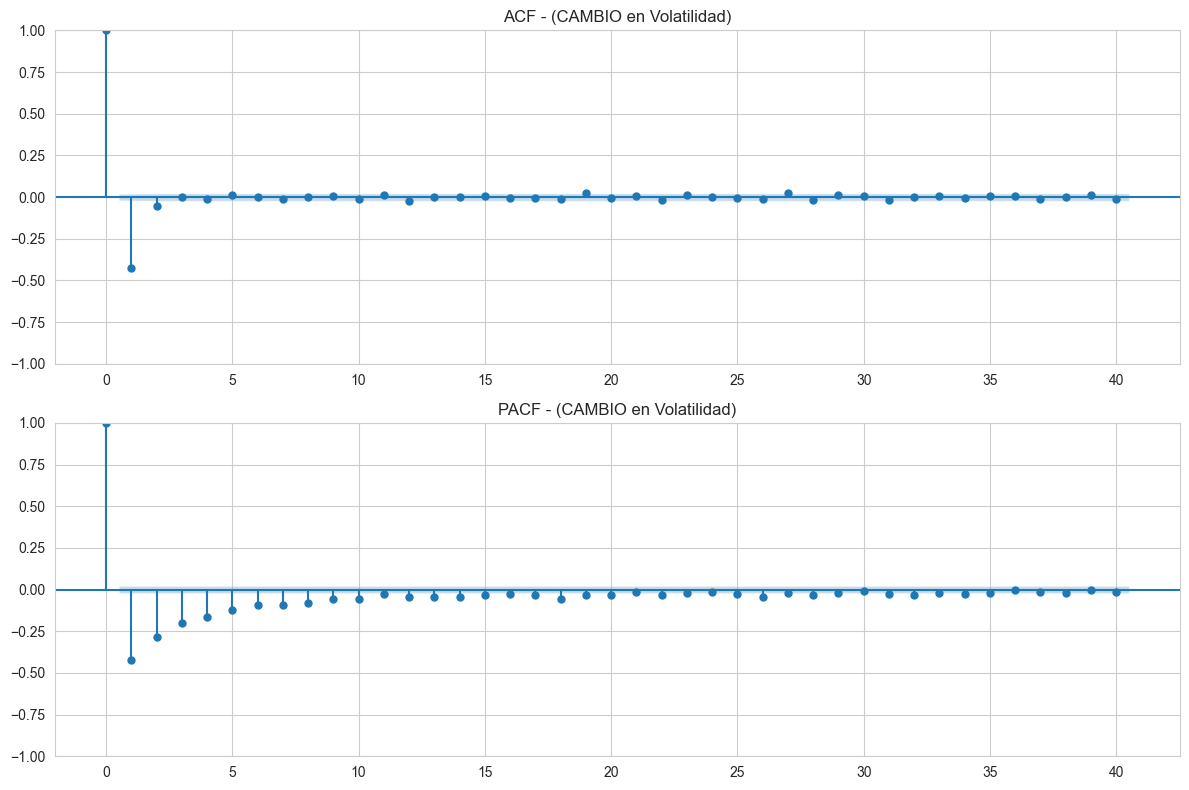

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


print("\n Gráficos ACF/PACF sobre el CAMBIO de Volatilidad")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF
plot_acf(series_a_predecir, lags=40, ax=ax1)
ax1.set_title('ACF - (CAMBIO en Volatilidad)')

# PACF
plot_pacf(series_a_predecir, lags=40, ax=ax2, method='ywm')
ax2.set_title('PACF - (CAMBIO en Volatilidad)')

plt.tight_layout()
plt.show()

**Interpretación de los Gráficos de Autocorrelación (ACF/PACF):**

Estos gráficos confirman los hallazgos del test ADF y nos dan la justificación final para nuestros modelos:

1.  **ACF (Gráfico Superior):** La autocorrelación decae rápidamente (muere) después de los primeros *lags*. Este es el comportamiento visual clásico de una serie estacionaria, a diferencia de la gráfica del "Paseo Aleatorio" (del precio) que vimos anteriormente.

2.  **PACF (Gráfico Inferior):** Esta es la clave. Observamos **múltiples picos estadísticamente significativos** (fuera de la zona azul) en los primeros *lags* (días).

**Conclusión:** El gráfico PACF demuestra que el cambio de volatilidad de **HOY** está directamente influenciado no solo por el de **AYER** (lag 1), sino también por el de **hace 2, 3, 5, 7, etc., días**.

La señal tiene **"memoria a corto plazo"**. El propósito de una red LSTM o un Transformer es, precisamente, mirar una secuencia de días pasados para aprender estos patrones de "memoria". Estos gráficos prueban que **esos patrones SÍ existen** en los datos y justifican plenamente el uso de estas arquitecturas.

## 6. Conclusión del Análisis Exploratorio

El conjunto de datos `Apple.csv` está **limpio y completo**, con 10,836 registros y sin valores nulos.

Se identificó **una única anomalía** (un día con volumen 0) que será tratada en el preprocesamiento.

El análisis de la **variable objetivo (`volatility`)** confirma la hipótesis del "clustering de volatilidad" (ver Gráfico 4), lo cual es esencial para que los modelos de series temporales funcionen.

El **mapa de correlación** valida nuestra selección de *features*, mostrando que la volatilidad pasada (`volatility`, `realized_vol_5d`) y el rango del día (`return_range`) tienen una correlación estadísticamente relevante con nuestro *target* (`target_delta_vol`).

El análisis estadístico de series temporales nos dice además que:

Es un problema Estacionario: A diferencia del precio en crudo, el test de Dickey-Fuller (p-value < 0.05) prueba estadísticamente que nuestro *target* (`target_delta_vol`) es estacionario. Esto significa que es una señal predecible.

Tiene Memoria a Corto Plazo: Los **gráficos ACF/PACF** muestran múltiples lags significativos, probando que el target de hoy depende de los valores de los últimos días (y no solo de ayer).

Este análisis confirma que el dataset es robusto y que estamos intentando predecir una señal que es estacionaria y tiene memoria, justificando plenamente el uso de arquitecturas avanzadas como LSTM y Transformer para capturar dichos patrones y **predecir el cambio en la volatilidad**